# Lab 1 - Training a Machine Learning Model

The goal of this lab is to demonstarte how Azure Machine Learning service can be used to manage, and accelerate machine learning **training workflows**. 

To keep the focus of the lab on **workflow orchestration** rather then a complex domain problem, we have chosen a relatively simple machine learning scenario.


## Scenario

You will train a binary classification model to predict customer churn. The dataset used in the lab is a synthetic dataset from a fictional telecomunication company. The dataset contains information about the subscribers, including demographic information, a summary of transaction history, and a churn indicator.

## Connect AML workspace

Check the version of AML SDK.

In [1]:
# Verify AML SDK Installed

import azureml.core
print("SDK Version:", azureml.core.VERSION)

SDK Version: 1.0.2


Connect to the workspace.

In [2]:
from azureml.core import Workspace

# Connect to workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')

Found the config file in: /Users/jarekk/repos/jakazmie/AMLsWorkshop/aml_config/config.json
jkamlsworkshop
jkamlsworkshop
westus2
952a710c-8d9c-40c1-9fec-f752138cc0b3


## Prepare training data
### Download the dataset
The dataset can be downloaded from a public Azure Blob Storage container.

In [3]:
import os

folder = '../datasets'
filename = 'TelcoCustomerChurn.csv'
os.makedirs(folder, exist_ok=True)

downloadCommand = 'wget -O ''{0}/{1}'' ''https://azureailabs.blob.core.windows.net/churn/{1}'''.format(folder, filename)
print(downloadCommand)
os.system(downloadCommand)

os.listdir(folder)


wget -O ../datasets/TelcoCustomerChurn.csv https://azureailabs.blob.core.windows.net/churn/TelcoCustomerChurn.csv


['TelcoCustomerChurn.csv',
 'UsedCars_Clean.csv',
 'UsedCars_Affordability.csv',
 'Chicago-Crimes-2018.csv']

### Explore the dataset

Infer and check the schema.

In [97]:
# Load the data

import numpy as np
import pandas as pd
import os

folder = '../datasets'
filename = 'TelcoCustomerChurn.csv'
pathname = os.path.join(folder, filename)
df = pd.read_csv(pathname, delimiter=',')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20468 entries, 0 to 20467
Data columns (total 29 columns):
age                                     20468 non-null int64
annualincome                            20468 non-null int64
calldroprate                            20468 non-null float64
callfailurerate                         20468 non-null float64
callingnum                              20468 non-null int64
customerid                              20468 non-null int64
customersuspended                       20468 non-null object
education                               20468 non-null object
gender                                  20468 non-null object
homeowner                               20468 non-null object
maritalstatus                           20468 non-null object
monthlybilledamount                     20468 non-null int64
noadditionallines                       20468 non-null object
numberofcomplaints                      20468 non-null int64
numberofmonthunpaid        

Summarize numeric columns.

In [5]:
df.describe()

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,penaltytoswitch,totalminsusedinlastmonth,unpaidbalance,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
count,20468.000000,20468.000000,20468.000000,20468.000000,2.046800e+04,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.0,20468.000000
mean,45.334327,124446.818253,0.035021,0.015239,4.220203e+09,4757.953342,59.630252,1.499169,3.489252,49.366816,248.792603,249.740522,126.656879,0.496528,3521.696306,721.521057,0.091020,2015.0,1.611687
std,19.624577,72129.392001,0.022996,0.011213,3.365196e+08,2751.070062,34.652681,1.119153,2.289740,28.874138,144.247247,144.198066,70.367800,0.288220,1959.642260,225.677596,0.287645,0.0,0.621895
min,12.000000,4.000000,0.000000,0.000000,1.022955e+08,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.0,1.000000
25%,28.000000,61898.000000,0.010000,0.010000,4.251031e+09,2372.750000,29.000000,0.000000,1.000000,24.000000,124.000000,126.000000,66.000000,0.250000,2047.750000,582.000000,0.000000,2015.0,1.000000
50%,45.000000,123689.500000,0.040000,0.020000,4.251054e+09,4754.000000,60.000000,2.000000,3.000000,49.000000,249.000000,249.000000,122.000000,0.500000,3365.000000,721.000000,0.000000,2015.0,2.000000
75%,62.000000,187065.250000,0.060000,0.030000,4.251077e+09,7141.250000,90.000000,3.000000,5.000000,74.000000,373.000000,374.000000,191.000000,0.750000,4786.250000,862.000000,0.000000,2015.0,2.000000
max,79.000000,249987.000000,0.070000,0.030000,4.251100e+09,9525.000000,119.000000,3.000000,7.000000,99.000000,499.000000,499.000000,249.000000,0.990000,16662.000000,1439.000000,1.000000,2015.0,3.000000


Summarize non-numeric columns

In [98]:
df.describe(exclude=np.number)

,customersuspended,education,gender,homeowner,maritalstatus,noadditionallines,occupation,state,usesinternetservice,usesvoiceservice
count,20468,20468,20468,20468,20468,20468,20468,20468,20468,20468
unique,2,4,2,2,2,1,3,50,2,2
top,Yes,High School or below,Female,Yes,Single,\N,Others,HI,No,No
freq,20026,10217,10474,16380,10446,20468,8189,478,19675,18598


Check for *null* values.

In [99]:
df[df.isnull().any(axis=1)]

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month


The datasets contains 20468 records. Each record comprises 29 columns. The columns are a mix of numeric and categorical data types.

The `churn` column indicates whether the customer changed providers. This is our `target` variable or `label`. The goal of the model we are going to train is to predict this column on new examples.

Some of the columns - e.g. `customerid`, `callingnum`, and record date  are irrelevant in the context of our predictive task and may even *leak the target*. We will remove them from the training dataset.
`noadditionallines` has a single value in all rows.

With exception of `state` all categorical features are low-cardinality.

There aren't any missing values or obvious outliers.

There are some suspicious records. The first two records indicate that a 12 year old makes over $160,000 a year. Although possible, it is highly improbable.

Let's drill down a little bit.

In [100]:
df[(df.age < 14) & (df.annualincome > 100000)]

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
0,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,...,15,19,No,No,0.82,5971,663,0,2015,1
1,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,...,15,19,No,No,0.82,3981,995,0,2015,2
78,13,130846,0.01,0.02,4251081945,36,Yes,Bachelor or equivalent,Male,Yes,...,117,159,No,No,0.61,3994,998,0,2015,1
79,13,130846,0.01,0.02,4251081945,36,Yes,Bachelor or equivalent,Male,Yes,...,117,159,No,No,0.61,4002,1000,0,2015,2
80,13,130846,0.01,0.02,4251081945,36,Yes,Bachelor or equivalent,Male,Yes,...,117,159,No,No,0.61,1083,1083,0,2015,3
486,12,175164,0.04,0.01,4251029437,225,Yes,High School or below,Female,Yes,...,45,192,No,No,0.85,1560,520,1,2015,1
487,12,175164,0.04,0.01,4251029437,225,Yes,High School or below,Female,Yes,...,45,192,No,No,0.85,1358,1358,1,2015,2
597,12,148399,0.03,0.02,4251099881,275,Yes,High School or below,Female,Yes,...,53,66,Yes,Yes,0.53,5283,880,0,2015,1
598,12,148399,0.03,0.02,4251099881,275,Yes,High School or below,Female,Yes,...,53,66,Yes,Yes,0.53,5778,577,0,2015,2
628,12,158933,0.07,0.02,4251032404,290,Yes,Master or equivalent,Male,Yes,...,458,51,No,No,0.41,2821,705,0,2015,2


There are 321 records of kids younger than 14 (14 is a legal employment age in US) making more than $100,000. For the sake of this lab we will assume that these are errorneous records and remove them.

We will also remove non-informative columns identified before.

### Clean the dataset

In [102]:
clean_df = df[~((df.age < 14) & (df.annualincome > 100000))]\
.drop(['customerid', 'callingnum', 'year', 'month', 'noadditionallines'], axis=1)
clean_df

,age,annualincome,calldroprate,callfailurerate,customersuspended,education,gender,homeowner,maritalstatus,monthlybilledamount,...,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn
2,42,29047,0.05,0.01,Yes,Bachelor or equivalent,Female,Yes,Single,8,...,43,WI,212,34,No,Yes,0.27,7379,737,0
3,42,29047,0.05,0.01,Yes,Bachelor or equivalent,Female,Yes,Single,8,...,43,WI,212,34,No,Yes,0.27,1729,432,0
4,58,27076,0.07,0.02,Yes,Master or equivalent,Female,Yes,Single,16,...,403,KS,216,144,No,No,0.48,3122,624,0
5,58,27076,0.07,0.02,Yes,Master or equivalent,Female,Yes,Single,16,...,403,KS,216,144,No,No,0.48,2769,553,0
6,20,137977,0.05,0.03,Yes,PhD or equivalent,Male,No,Single,74,...,76,KY,412,159,Yes,No,0.94,834,834,0
7,20,137977,0.05,0.03,Yes,PhD or equivalent,Male,No,Single,74,...,76,KY,412,159,Yes,No,0.94,5868,838,0
8,36,136006,0.07,0.00,Yes,High School or below,Male,Yes,Married,81,...,436,ND,416,19,No,No,0.15,1886,628,0
9,36,136006,0.07,0.00,Yes,High School or below,Male,Yes,Married,81,...,436,ND,416,19,No,No,0.15,2602,867,0
10,67,246906,0.05,0.01,Yes,High School or below,Female,Yes,Married,19,...,108,OK,113,34,No,No,0.61,2737,391,0
11,67,246906,0.05,0.01,Yes,High School or below,Female,Yes,Married,19,...,108,OK,113,34,No,No,0.61,5845,835,0


### Analyze label distribution

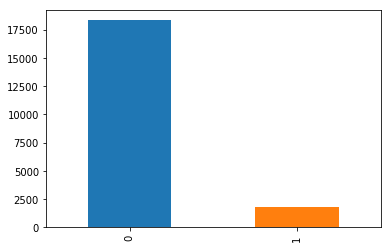

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt

clean_df.churn.value_counts().plot.bar()

Our dataset is very imbalanced. Training a classificatin model on an imbalanced dataset may be challening. Decision trees based algorithms often perform well on imbalanced datasets because their hierarchical structure allows them to learn signals from both classes. In modern applied machine learning, tree ensembles (Random Forests, Gradient Boosted Trees, etc.) almost always outperform singular decision trees.

In the lab, we are going to use `sklearn` *Random Forest Classifier*.

To father mitigate class imbalance, we are also going to utilize *undersampling*.

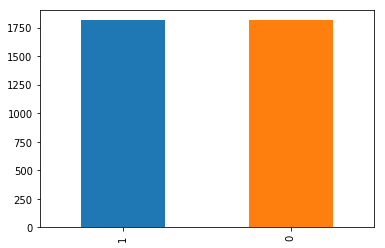

In [104]:
# Undersample training data
count_class_0, count_class_1 = clean_df.churn.value_counts()

df_class_0 = clean_df[clean_df.churn == 0]
df_class_1 = clean_df[clean_df.churn == 1]

df_class_0_under = df_class_0.sample(1 * count_class_1)
df_undersampled = pd.concat([df_class_0_under, df_class_1], axis=0)

df_undersampled.churn.value_counts().plot.bar()

## Train the model

In this section of the lab you will train a binary classification model using *RandomForestClassifier* algorithm from `scikit-learn`. 

You will first run training on a local compute and use Azure Machine Learning Experiment to track training progress. In the following step, you will use Azure Machine Learning Compute to run  training job on more powerful and elastically scaleable cloud compute resources.



### Prepare training pipeline

#### Configure feature transformations

All `scikit-learn` estimators expect continuous input. Some of the features in the dataset are categorical and encoded as `strings`. We will use *one-hot* encoding for low-cardinality categorical features and *hashing trick* for `state` that is the only high-cardinality feature.

In [106]:
# Split features and labels
X_raw = df_undersampled.drop(['churn'], axis=1)
#X_raw = clean_df.drop(['churn'], axis=1)
#y = clean_df.churn
y = df_undersampled.churn

# One hot encode all categorical features but `state`
from sklearn.preprocessing import OneHotEncoder
ohenc = OneHotEncoder(sparse=False)

# Use feature hasing to encode `state`
from sklearn.feature_extraction import FeatureHasher
fh = FeatureHasher(n_features=6, input_type='string')

# Combine feature transformations
from sklearn.compose import ColumnTransformer

columns = X_raw.drop('state', axis=1).select_dtypes(include=[object]).columns
ct = ColumnTransformer(
    [('onehot', ohenc, columns),
    ('hashing', fh, 'state')],
    remainder='passthrough')

# Test a transformation pipeline
pd.DataFrame(ct.fit_transform(X_raw[0:20]))

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,53.0,2.0,2.0,13.0,164.0,461.0,177.0,0.52,5656.0,707.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,43.0,3.0,3.0,80.0,117.0,429.0,116.0,0.61,7511.0,751.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,12.0,3.0,3.0,37.0,411.0,403.0,49.0,0.09,2252.0,1126.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,100.0,1.0,6.0,68.0,267.0,383.0,140.0,0.68,543.0,181.0
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,16.0,3.0,2.0,24.0,70.0,129.0,165.0,0.42,3027.0,504.0
5,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,58.0,3.0,4.0,82.0,82.0,400.0,76.0,0.80,1634.0,817.0
6,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,25.0,2.0,3.0,3.0,287.0,174.0,140.0,0.45,5630.0,625.0
7,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,111.0,1.0,0.0,73.0,274.0,109.0,63.0,0.38,1361.0,453.0
8,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,2.0,0.0,0.0,20.0,168.0,486.0,22.0,0.06,1196.0,1196.0
9,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,118.0,0.0,2.0,97.0,330.0,497.0,139.0,0.70,6376.0,1062.0


#### Configure training 

*RandomForestClassifier* exposes a number of tuneable hyperparameters. Argueable, the most important settings are the number of trees in the forest *(n_estimators)* and the number of features considered for splitting at each leaf node *(max_features)*. For the sake of simplicity, we will focus on tuning these two hyperparameters when training our model. We will use *GridSearchCV* to automate the hyperparameter tuning process.

In [109]:
#X = ct.fit_transform(X_raw.drop('state', axis=1))
X = ct.fit_transform(X_raw)

X.shape

(3628, 39)

In [116]:


# Configure RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators=100, max_features=10, random_state=42)
#gbt = GradientBoostingClassifier()

scores = cross_val_score(
    gbt, X, y, cv=5, scoring="recall")
scores


array([0.75482094, 0.75757576, 0.75482094, 0.83195592, 0.80110497])

In [ ]:
from sklearn.model_selection import train_test_split

X = clean_df.drop("churn", axis=1)
y = clean_df.churn

train_X, test_X, train_Y, test_Y =\
train_test_split(X, y, 
                 train_size=0.75,
                 shuffle=True,
                 stratify=y,
                 random_state=42)
    

### Run training on a local compute


In [ ]:
# Configure RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(random_state=42)

scores = cross_val_score(
    rf, X, y, cv=3, scoring="accuracy")
scores

In [ ]:
# Define a method to experiment with different values of C

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
full_X = df_affordability[["Age", "KM"]]
full_Y = df_affordability[["Affordable"]]

def train_eval_model(full_X, full_Y,training_set_percentage, C):
    train_X, test_X, train_Y, test_Y = train_test_split(full_X, full_Y, train_size=training_set_percentage, random_state=42)
    
    # Flatten labels
    train_Y = np.ravel(train_Y)
    test_Y = np.ravel(test_Y)
    
    # Convert to float
    train_X = train_X.astype(float)
    test_X = test_X.astype(float)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(train_X)
    clf = linear_model.LogisticRegression(C=C, solver='lbfgs')
    clf.fit(X_scaled, train_Y)

    scaled_inputs = scaler.transform(test_X)
    predictions = clf.predict(scaled_inputs)
    score = accuracy_score(test_Y, predictions)

    return (clf, score)

## Use Azure Machine Learning to log performance metrics
In the steps that follow, you will train multiple models using different values of C and observe the impact on performance (accuracy). Each time you create a new model, you are executing a Run in the terminology of Azure Machine Learning service. In this case, you will create one Experiment and execute multiple Runs within it, each with different value of C.

Execute the following cell to quickly verify you have the Azure Machine Learning SDK installed on your cluster. If you get a version number back without error, you are ready to proceed.

To begin capturing metrics, you must first create an Experiment and then call `start_logging()` on that Experiment. The return value of this call is a Run. This root run can have other child runs. When you are finished with an experiment run, use `complete()` to close out the root run. Execute the following cell to train four different models using differing amounts of training data and log the results to Azure Machine Learning.

In [ ]:
# Create an experiment and log metrics for multiple training runs

from azureml.core.run import Run
from azureml.core.experiment import Experiment

# start a training run by defining an experiment
myexperiment = Experiment(ws, "usedcars_training_local")
root_run = myexperiment.start_logging()

training_set_percentage = 0.25
C = 2
run = root_run.child_run("Training_Set_Percentage-%0.5F" % training_set_percentage)
model, score = train_eval_model(full_X, full_Y, training_set_percentage, C)
print("With C={}, model accuracy reached {}".format(C, score))
run.log("Training_Set_Percentage", training_set_percentage)
run.log("C", C)
run.log("Accuracy", score)
run.complete()

C = 1
run = root_run.child_run("Training_Set_Percentage-%0.5F" % training_set_percentage)
model, score = train_eval_model(full_X, full_Y, training_set_percentage, C)
print("With C={}, model accuracy reached {}".format(C, score))
run.log("Training_Set_Percentage", training_set_percentage)
run.log("C", C)
run.log("Accuracy", score)
run.complete()

C = 0.75
run = root_run.child_run("Training_Set_Percentage-%0.5F" % training_set_percentage)
model, score = train_eval_model(full_X, full_Y, training_set_percentage, C)
print("With C={}, model accuracy reached {})".format(C, score))
run.log("Training_Set_Percentage", training_set_percentage)
run.log("C", C)
run.log("Accuracy", score)
run.complete()

C = 0.5
run = root_run.child_run("Training_Set_Percentage-%0.5F" % training_set_percentage)
model, score = train_eval_model(full_X, full_Y, training_set_percentage, C)
print("With C={}, model accuracy reached {})".format(C, score))
run.log("Training_Set_Percentage", training_set_percentage)
run.log("C", C)
run.log("Accuracy", score)
run.complete()

# Close out the experiment
root_run.complete()

Now that you have captured history for various runs, you can review the runs. You could use the Azure Portal for this - go to the Azure Portal, find your Azure Machine Learning Workspace, select Experiments and select the UsedCars_Experiment. However, in this case we will use the AML SDK to query for the runs. Execute the following cell to view the runs and their status.

In [ ]:
# Review captured runs
# Go to the Azure Portal, find your Azure Machine Learning Workspace, select Experiments and select the UsedCars_Experiment

# You can also query the run history using the SDK.
# The following command lists all of the runs for the experiment
runs = [r for r in root_run.get_children()]
print(runs)

## Train remotely using Azure ML Compute

Up until now, all of your training was executed locally on the same machine running Jupyter. Now you will execute the same logic targeting a remote Azure ML Compute, which you will provision from code.

In [ ]:
# Connect to workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')

In [ ]:
# Create an Azure ML Compute cluster

# Create Azure ML cluster
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
cluster_name = "cpu-bai-cluster"
cluster_min_nodes = 1
cluster_max_nodes = 3
vm_size = "STANDARD_DS11_V2"

if cluster_name in ws.compute_targets:
    compute_target = ws.compute_targets[cluster_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('Found existing compute target, using this compute target instead of creating:  ' + cluster_name)
    else:
        print("Error: A compute target with name ",cluster_name," was found, but it is not of type AmlCompute.")
else:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size, 
                                                                min_nodes = cluster_min_nodes, 
                                                                max_nodes = cluster_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current BatchAI cluster status, use the 'status' property    
    print(compute_target.status.serialize())

With your cluster ready, you need to upload the training data to the default DataStore for your AML Workspace (which uses Azure Storage). 

In [ ]:
# Upload the dataset to the DataStore

ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)
ds.upload(src_dir='../datasets', target_path='used_cars', overwrite=True, show_progress=True)

Next, you will need to create a training script that is similar to the code you have executed locally to train the model. 

In [ ]:
import os
script_folder = './script'
os.makedirs(script_folder, exist_ok=True)

In [ ]:
%%writefile $script_folder/train.py

import argparse
import os
import numpy as np
import pandas as pd

from sklearn import linear_model 
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from azureml.core import Run

# let user feed in 2 parameters, the location of the data files (from datastore), and the training set percentage to use
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--training-set-percentage', type=float, dest='training_set_percentage', default=0.25, help='percentage of dataset to use for training')
parser.add_argument('--C', type=float, dest='C', default=1, help='regularization')
args = parser.parse_args()

data_folder = os.path.join(args.data_folder, 'used_cars')
print('Data folder:', data_folder)
data_csv_path = os.path.join(data_folder, 'UsedCars_Clean.csv')
print('Path to CSV file dataset:' + data_csv_path)

# Load the data
#df = pd.read_csv('UsedCars_Clean.csv', delimiter=',')
df = pd.read_csv(data_csv_path)
df['Affordable'] = np.where(df['Price']<12000, 1, 0)
df_affordability = df[["Age","KM", "Affordable"]]


# Now experiment with different training subsets
from sklearn.model_selection import train_test_split
full_X = df_affordability[["Age", "KM"]]
full_Y = df_affordability[["Affordable"]]

def train_eval_model(full_X, full_Y,training_set_percentage, C):
    train_X, test_X, train_Y, test_Y = train_test_split(full_X, full_Y, train_size=training_set_percentage, random_state=42)
    
    # Flatten labels
    train_Y = np.ravel(train_Y)
    test_Y = np.ravel(test_Y)
    
    # Convert to float
    train_X = train_X.astype(float)
    test_X = test_X.astype(float)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(train_X)
    clf = linear_model.LogisticRegression(C=C, solver='lbfgs')
    clf.fit(X_scaled, train_Y)

    scaled_inputs = scaler.transform(test_X)
    predictions = clf.predict(scaled_inputs)
    score = accuracy_score(test_Y, predictions)

    return (clf, score)

# Acquire the current run
run = Run.get_context()


training_set_percentage = args.training_set_percentage
C = args.C
model, score = train_eval_model(full_X, full_Y, training_set_percentage, C)
print("With C={}, model accuracy reached {})".format(C, score))
run.log("Training_Set_Percentage", training_set_percentage)
run.log("C", C)
run.log("Accuracy", score)


# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=model, filename='outputs/model.pkl')


Create an estimator that descrives the configuration of the job that will execute your model training script.

In [ ]:
# Create estimator
#############################
from azureml.train.estimator import Estimator

script_params = {
    '--data-folder': ds.as_mount(),
    '--training-set-percentage': 0.3,
    '--C': 2
}

est_config = Estimator(source_directory=script_folder,
                       script_params=script_params,
                       compute_target=compute_target,
                       entry_script='train.py',
                       conda_packages=['scikit-learn', 'pandas'])

Submit the job using the submit() method of the Experiment object. 

In [ ]:
#  Execute the estimator job
#####################################

# Create new experiment
from azureml.core import Experiment
experiment_name = "usedcars_training_amlcompute"
exp = Experiment(workspace=ws, name=experiment_name)

run = exp.submit(config=est_config)
run


You can monitor the job through Azure Portal or using AML Jupyter Widget.

In [ ]:
from azureml.widgets import RunDetails
RunDetails(run).show()


In [ ]:
# Poll for job status
run.wait_for_completion(show_output=True)  # value of True will display a verbose, streaming log

# Examine the recorded metrics from the run
print(run.get_metrics())